# Financial bubble prediction using the LPPL model

### Wolfgang Plaschg, wolfgang.plaschg@gmail.com

LPPL model

$$ \mathbb{E}[\ln(p(t))] = A + B(t_c - t)^m + C(t_c - t)^m\cos(\omega\ln(t_c - t) - \phi) $$

with

$$
\begin{align}
0.1 \leq{} m & \leq 0.9 \\
6 \leq{}  \omega & \leq 13 \\
 |C\,| & \le 1 \\
 B & \le 0
\end{align}
$$

A model example:

![model example](https://i.imgur.com/VSSHKAA.png)

A data example:

![data](https://i.imgur.com/lDiiSxW.png)

We want to fit a model for a given data:

![model + data](https://i.imgur.com/WwOtMss.png)

The original model has 7 parameters $A$, $B$, $C$, $m$, $\omega$, $\phi$ and $t_c$ but can be reduced to a non-linear optimization problem in 3 variables:

![alt text](https://i.imgur.com/z6WyzRv.png)

Example: Bitcoin bubble

![alt text](https://i.imgur.com/zpt3RMK.png)

In [0]:
%pylab inline
import scipy
import pandas as pd

# disable warnings
np.seterr(divide='ignore', invalid='ignore', over='ignore')

Populating the interactive namespace from numpy and matplotlib


{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [0]:
DATA_SIZE = 400
NOISE_FACTOR = 0.5
CUTOFF = 0.8

## Generate a model and test data

tc: 1.25


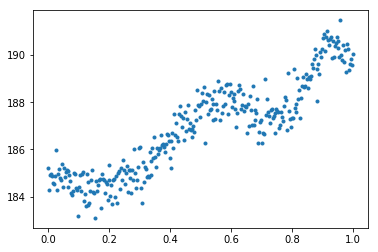

In [0]:
# LPPL 4 factor model

tc = 6
m = np.random.uniform(0.1, 0.9)     # 0.1 <= m <= 0.9
omega = np.random.uniform(6, 13)  # 6 <= omega <= 13

C = abs(np.random.normal())    # |C| < 1
B = np.random.uniform(-10, 0)      # B < 0
A = 200
phi = 10

t = np.linspace(0, tc, num=DATA_SIZE)
line_data = A + B * (tc - t) ** m + C * (tc - t) ** m * np.cos(omega * np.log(tc - t) - phi)
line_data_index = np.linspace(0, tc, len(line_data))
log_prices = [x + np.random.normal(0, NOISE_FACTOR) for x in line_data]
log_prices = log_prices[:int(DATA_SIZE * CUTOFF)]
t_cutoff = t[:int(DATA_SIZE * CUTOFF)]
factor = 1 / max(t_cutoff)
t_cutoff = t_cutoff * factor
line_data_index = line_data_index * factor
t = t * factor
tc = max(t)

simulated_data = pd.Series(data=log_prices, index=t_cutoff)

print("tc: %.2f" % tc)
plot(simulated_data, '.')
# plot(line_data_index, line_data, 'b-')

## Generate test data using geometric brownian motion

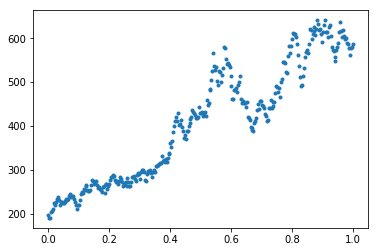

In [0]:
# x0 = start value, mu = drift, sigma = volatility

def make_gbm_data(x0=200, mu=0.8, sigma=0.6, data_size=DATA_SIZE):
    n = int(data_size * CUTOFF)
    dt = 1/n
    x = pd.DataFrame()
    t = np.linspace(0, 1, n)
    step = np.exp((mu - sigma**2 / 2) * dt) * np.exp(sigma * np.random.normal(0, np.sqrt(dt), (1, n)))
    return pd.Series(data = x0 * step.cumprod(), index=t)

gbm_data = make_gbm_data()

plot(gbm_data, '.')

tc: 1.25


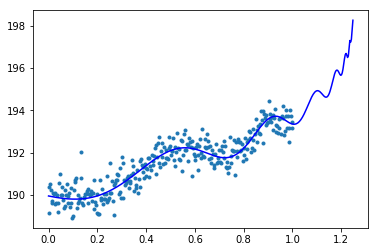

In [0]:
# LPPL 3 factor model

C1 = C * np.cos(phi)
C2 = C * np.sin(phi)

line_data = A + B * (tc - t) ** m + C1 * (tc - t) ** m * np.cos(omega * np.log(tc - t)) + \
            C2 * (tc - t) ** m * np.sin(omega * np.log(tc - t))
line_data_index = np.linspace(0, tc, len(line_data))
log_prices = [x + np.random.normal(0, NOISE_FACTOR) for x in line_data]
log_prices = log_prices[:int(DATA_SIZE * CUTOFF)]
t_cutoff = t[:int(DATA_SIZE * CUTOFF)]
factor = 1 / max(t_cutoff)
t_cutoff = t_cutoff * factor
line_data_index = line_data_index * factor
t = t * factor
tc = max(t)

simulated_data = pd.Series(data=log_prices, index=t_cutoff)

print("tc: %.2f" % tc)
plot(simulated_data, '.')
plot(line_data_index, line_data, 'b-')

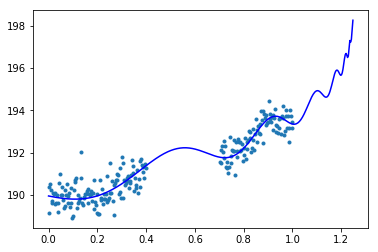

In [0]:
# delete data points
import copy
cutout_data = copy.deepcopy(simulated_data)
del_ival = []
for i in range(len(cutout_data.index)):
    ival = cutout_data.index[i]
    if ival >= 0.4 and ival <= 0.7:
        del_ival.append(ival)
for ival in del_ival:
    del cutout_data[ival]

plot(cutout_data, '.')
plot(line_data_index, line_data, 'b-')

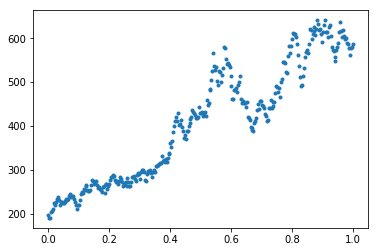

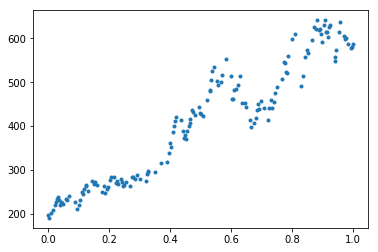

In [0]:
def reduce_data(data, target_size):
    while len(data) > target_size:
        del_keys = np.random.choice(data.index, len(data.index) - target_size)
        removed = 0
        for k in del_keys:
            try:
                del data[k]
                removed += 1
            except:
                pass
reduced_data = gbm_data.copy()
reduce_data(reduced_data, 159)
plot(gbm_data, '.')
figure()
plot(reduced_data, '.')

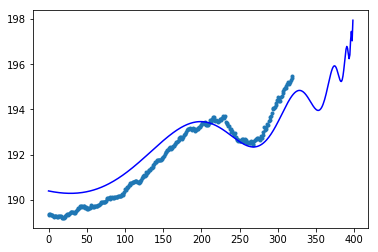

In [0]:
x = gbm_data.values

x1 = min(gbm_data.values)
x2 = max(gbm_data.values)
b = (x1 + x2) / (x1 - x2)
a = (-1 - b) / x1
scaled = np.array(gbm_data.values) * a + b

data = line_data[:int(DATA_SIZE * CUTOFF)] + scaled * 1.1
gbm_sim_data = pd.Series(data, index=t_cutoff)

plot(gbm_sim_data.values, '.')
plot(line_data, 'b-')

In [0]:
def F1_get_linear_parameters(X, stock_data):
    tc, m, omega = X
    
    t = np.array(stock_data.index)
    y = np.array(stock_data.values)
    
    N = len(stock_data)
    f = (tc - t) ** m
    g = (tc - t) ** m * np.cos(omega * np.log(tc - t))
    h = (tc - t) ** m * np.sin(omega * np.log(tc - t))
    
    LHS = np.array([[N,      sum(f),    sum(g),    sum(h)   ],
                    [sum(f), sum(f**2), sum(f*g),  sum(f*h) ],
                    [sum(g), sum(f*g),  sum(g**2), sum(g*h) ],
                    [sum(h), sum(f*h),  sum(g*h),  sum(h**2)]])
                    
    RHS = np.array([[sum(y)], 
                    [sum(y*f)],
                    [sum(y*g)],
                    [sum(y*h)]])
                    
    A, B, C1, C2 = np.linalg.solve(LHS, RHS)
    return A, B, C1, C2

def F1(X, stock_data):
    tc, m, omega = X
    t = np.array(stock_data.index)
    y = np.array(stock_data.values)
    A, B, C1, C2 = F1_get_linear_parameters(X, stock_data)
    error = y - A - B * (tc - t) ** m - C1 * (tc - t) ** m * np.cos(omega * np.log(tc - t)) - \
                C2 * (tc - t) ** m * np.sin(omega * np.log(tc - t))
    cost = sum(error ** 2)
    return cost    

def F1_normalized(result, stock_data):
    x1 = min(stock_data.values)
    x2 = max(stock_data.values)
    b = (x1 + x2) / (x1 - x2)
    a = (-1 - b) / x1
    data = np.array(stock_data.values) * a + b
    stock_data_norm = pd.Series(data=data, index=stock_data.index)
    return F1(result, stock_data_norm)

from scipy import optimize 

class Result:
    def __init__(self):
        self.success = None

        # model parameters 
        self.tc = None
        self.m = None
        self.omega = None
        self.A = None
        self.B = None
        self.C1 = None
        self.C2 = None
        self.C = None
        self.pruned = None   # True if one of the parameters has been pruned to the 
                             # valid range after fitting.
        self.price_tc = None  # Estimated price at tc
        self.price_chg = None  # Price difference between est. price at tc and last price in percent

        self.mse = None  # mean square error 
        self.mse_hist = []  # history of mean square errors
        self.norm_mse = None  # normalized mean square error
        self.opt_rv = None  # Return object from optimize function
        self.tc_start = []
        self.m_start = []
        self.omega_start = []
        
def LPPL_fit(data, tries=20, min_distance=0.2):
    rv = Result()
    fitted_parameters = None
    mse_min = None
    fitted_pruned = False

    tc_min, tc_max = 1, 1.6  # Critical time
    m_min, m_max = 0.1, 0.5  # Convexity: smaller is more convex
    omega_min, omega_max = 6, 13  # Number of oscillations

    # Scaling parameters to scale tc, m and omega to range 0 .. 1

    tc_scale_b = tc_min / (tc_min - tc_max)
    tc_scale_a = -tc_scale_b / tc_min

    m_scale_b = m_min / (m_min - m_max)
    m_scale_a = -m_scale_b / m_min

    omega_scale_b = omega_min / (omega_min - omega_max)
    omega_scale_a = -omega_scale_b / omega_min

    for n in range(tries):

        found = False

        while not found:
            tc_start = numpy.random.uniform(low=tc_min, high=tc_max)
            m_start = numpy.random.uniform(low=m_min, high=m_max)
            omega_start = numpy.random.uniform(low=omega_min, high=omega_max)
            found = True

            for i in range(len(rv.tc_start)):
                # Scale values to range 0 .. 1 
                # Calculate distance and reject starting point if too close to 
                # already used starting point
                a = np.array([tc_start * tc_scale_a + tc_scale_b,
                              m_start * m_scale_a + m_scale_b,
                              omega_start * omega_scale_a + omega_scale_b])
                b = np.array([rv.tc_start[i] * tc_scale_a + tc_scale_b, 
                              rv.m_start[i] * m_scale_a + m_scale_b, 
                              rv.omega_start[i] * omega_scale_a + omega_scale_b])
                distance = numpy.linalg.norm(a - b)
                if distance < min_distance:
                    found = False
                    # print("Points to close together: ", a, b)
                    break

        rv.tc_start.append(tc_start)
        rv.m_start.append(m_start)
        rv.omega_start.append(omega_start)

        x0 = [tc_start, m_start, omega_start]

        try:
            opt_rv = optimize.minimize(F1, x0, args=(data,), method='Nelder-Mead')    
            if opt_rv.success:

                tc_est, m_est, omega_est = opt_rv.x
                pruned = False

                if tc_est < tc_min:
                    tc_est = tc_min
                    pruned = True
                elif tc_est > tc_max:
                    tc_est = tc_max
                    pruned = True

                if m_est < m_min:
                    m_est = m_min
                    pruned = True
                elif m_est > m_max:
                    m_est = m_max
                    pruned = True

                if omega_est < omega_min:
                    omega_est = omega_min
                    pruned = True
                elif omega_est > omega_max:
                    omega_est = omega_max
                    pruned = True

                mse = F1([tc_est, m_est, omega_est], data)

                if mse_min is None or mse < mse_min:
                    fitted_parameters = [tc_est, m_est, omega_est]
                    fitted_pruned = pruned
                    mse_min = mse
                    rv.mse_hist.append(mse)
                else:
                    rv.mse_hist.append(mse_min)
        except LinAlgError as e:
            # print("Exception occurred: ", e)
            pass

    if fitted_parameters is not None:
        rv.tc, rv.m, rv.omega = fitted_parameters
        rv.A, rv.B, rv.C1, rv.C2 = F1_get_linear_parameters(fitted_parameters, data)
        rv.C = abs(rv.C1) + abs(rv.C2)
        rv.price_tc = rv.A + rv.B * (0.001) ** rv.m + \
                      rv.C1 * (0.001) ** rv.m * np.cos(rv.omega * np.log(0.001)) + \
                      rv.C2 * (0.001) ** rv.m * np.sin(rv.omega * np.log(0.001))
        rv.price_chg = (rv.price_tc - data.iat[-1]) / data.iat[-1] * 100
        rv.pruned = fitted_pruned
        rv.mse = mse_min
        rv.norm_mse = F1_normalized(fitted_parameters, data) / len(data) * 1000
        rv.success = True
    return rv

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()



== RESULTS ==
  price tc: 197.27 (196.52)
   tc:   real value:     1.25    estimation:     1.15
    m:   real value:     0.28    estimation:     0.30
omega:   real value:     8.16    estimation:     6.96
    A:   real value:   200.00    estimation:   198.19
    B:   real value:    -9.22    estimation:    -7.65
   C1:   real value:    -0.58    estimation:    -0.61
   C2:   real value:    -0.37    estimation:     0.20

== ERROR STATISTICS ==
Mean square error:                53.63
 MSE (normalized):                31.70


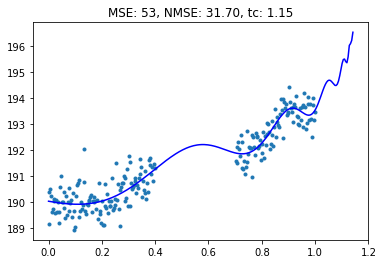

In [0]:
data = gbm_data
data = simulated_data
# data = gbm_sim_data
data = reduced_data
data = cutout_data

rv = LPPL_fit(data)

if rv.success:
    line_points = len(data.values) * rv.tc
    t_ = np.linspace(0, rv.tc, num=line_points)
    est_line_data = rv.A + rv.B * (rv.tc - t_) ** rv.m + \
                    rv.C1 * (rv.tc - t_) ** rv.m * np.cos(rv.omega * np.log(rv.tc - t_)) + \
                    rv.C2 * (rv.tc - t_) ** rv.m * np.sin(rv.omega * np.log(rv.tc - t_))
    est_line_data_index = np.linspace(0, rv.tc, len(est_line_data))

    price_tc = rv.A + rv.B * (0.001) ** rv.m + \
               rv.C1 * (0.001) ** rv.m * np.cos(rv.omega * np.log(0.001)) + \
               rv.C2 * (0.001) ** rv.m * np.sin(rv.omega * np.log(0.001))

    print()
    print("== RESULTS ==")
    print("  price tc: %.2f (%.2f)" % (price_tc, est_line_data[-2]))
    print("   tc:   real value: % 8.2f    estimation: % 8.2f" % (tc, rv.tc))
    print("    m:   real value: % 8.2f    estimation: % 8.2f" % (m, rv.m))
    print("omega:   real value: % 8.2f    estimation: % 8.2f" % (omega, rv.omega))
    print("    A:   real value: % 8.2f    estimation: % 8.2f" % (A, rv.A))
    print("    B:   real value: % 8.2f    estimation: % 8.2f" % (B, rv.B))
    print("   C1:   real value: % 8.2f    estimation: % 8.2f" % (C1, rv.C1))
    print("   C2:   real value: % 8.2f    estimation: % 8.2f" % (C2, rv.C2))
    print()
    print("== ERROR STATISTICS ==")
    print("Mean square error: % 20.2f" % (rv.mse,))
    print(" MSE (normalized): % 20.2f" % (rv.norm_mse,))

    plot(data.index, data.values, '.')
    plot(est_line_data_index, est_line_data, 'b-')
    title("MSE: %d, NMSE: %.2f, tc: %.2f" % (rv.mse, rv.norm_mse, rv.tc))

# Cost function plots
Model contraints
$$
\begin{align}
1 \leq{} & t_c \leq 4 \\
0.1 \leq{} & m \leq 0.9 \\
6 \leq{}  & \omega \leq 13 
\end{align}
$$

In [0]:
# Calculate values

MESH_SIZE = 100
LEVELS = 50

tc_est, m_est, omega_est = rv.tc, rv.m, rv.omega
tc_ = np.linspace(1.0, 4.0, MESH_SIZE)
m_ = np.linspace(0.1, 0.9, MESH_SIZE)
omega_ = np.linspace(6, 13, MESH_SIZE)

X1, Y1 = np.meshgrid(tc_, m_)
Z1 = np.zeros((MESH_SIZE, MESH_SIZE))
for i in range(len(tc_)):
    for j in range(len(m_)):
        Z1[i, j] = F1([tc_[i], m_[j], omega_est], data)

X2, Y2 = np.meshgrid(tc_, omega_)
Z2 = np.zeros((MESH_SIZE, MESH_SIZE))
for i in range(len(tc_)):
    for j in range(len(omega_)):
        Z2[i, j] = F1([tc_[i], m_est, omega_[j]], data)

X3, Y3 = np.meshgrid(m_, omega_)
Z3 = np.zeros((MESH_SIZE, MESH_SIZE))
for i in range(len(m_)):
    for j in range(len(omega_)):
        Z3[i, j] = F1([tc_est, m_[i], omega_[j]], data)



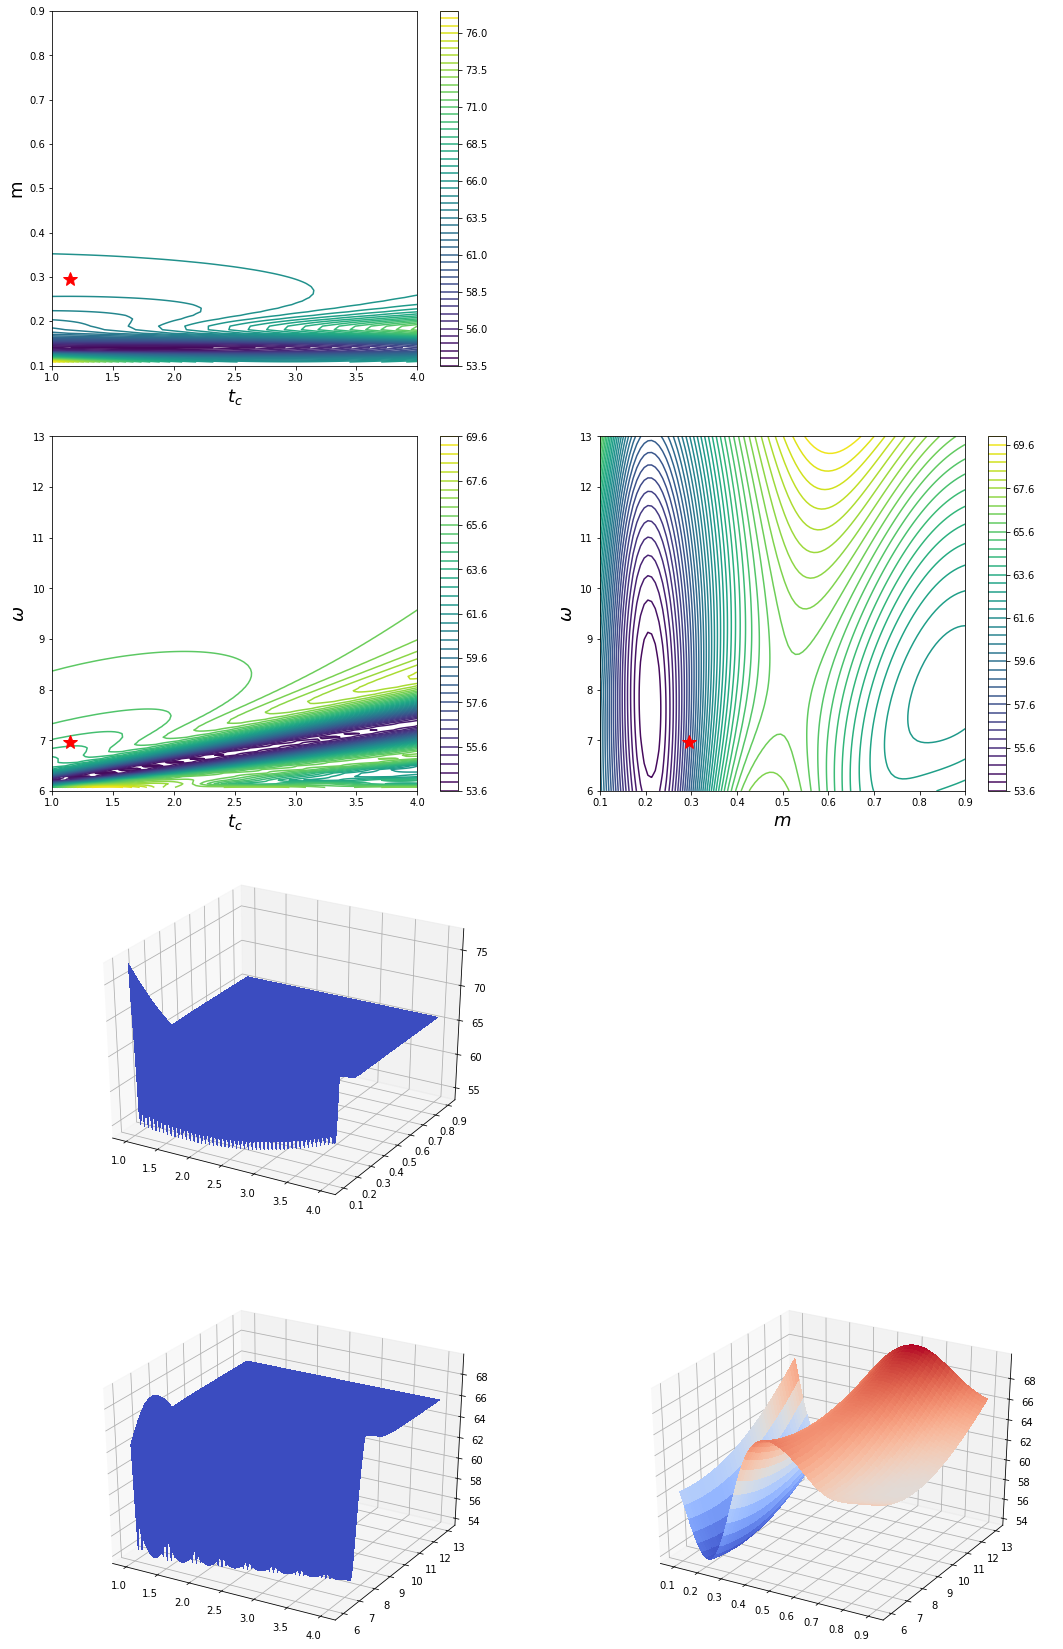

In [0]:
from mpl_toolkits.mplot3d.axes3d import get_test_data
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# Plot graph

fig = plt.figure(figsize=(18., 30.))

# Plot tc vs m
ax = fig.add_subplot(4, 2, 1)
c = ax.contour(X1, Y1, Z1, LEVELS)
# ax.plot(tc, m, 'ro', markersize=10)
# ax.plot(tc_est, m_est, 'r*', markersize=15)
ax.set_xlabel(r"$t_c$", fontsize=18)
ax.set_ylabel(r"m", fontsize=18)
ax.plot(tc_est, m_est, 'r*', markersize=15)
plt.colorbar(c, ax=ax)

# 3D surface
ax = fig.add_subplot(4, 2, 5, projection='3d')
surf = ax.plot_surface(X1, Y1, Z1, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Plot omega vs tc
ax = fig.add_subplot(4, 2, 3)
c = ax.contour(X2, Y2, Z2, LEVELS)
# ax.plot(tc, m, 'ro', markersize=10)
# ax.plot(tc_est, m_est, 'r*', markersize=15)
ax.set_xlabel(r"$t_c$", fontsize=18)
ax.set_ylabel(r"$\omega$", fontsize=18)
ax.plot(tc_est, omega_est, 'r*', markersize=15)
plt.colorbar(c, ax=ax)

# 3D surface
ax = fig.add_subplot(4, 2, 7, projection='3d')
surf = ax.plot_surface(X2, Y2, Z2, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Plot omega vs m
ax = fig.add_subplot(4, 2, 4)
c = ax.contour(X3, Y3, Z3, LEVELS)
# ax.plot(tc, m, 'ro', markersize=10)
# ax.plot(tc_est, m_est, 'r*', markersize=15)
ax.set_xlabel(r"$m$", fontsize=18)
ax.set_ylabel(r"$\omega$", fontsize=18)
ax.plot(m_est, omega_est, 'r*', markersize=15)
plt.colorbar(c, ax=ax)

# 3D surface
ax = fig.add_subplot(4, 2, 8, projection='3d')
surf = ax.plot_surface(X3, Y3, Z3, cmap=cm.coolwarm, linewidth=0, antialiased=False)